In [1]:
import dgl
import numpy as np
import pandas as pd
import torch

from dgl.data.utils import load_graphs, save_graphs

In [5]:
# !pip install dgl
# !pip install torch_geometric

In [2]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
graph, label_dict = load_graphs('data/tfinance/tfinance')
graph = graph[0]
graph.ndata['label'] = graph.ndata['label'].argmax(1)

In [3]:
graph.edges()

(tensor([    0,     0,     0,  ..., 39356, 39356, 39356]),
 tensor([20227,  1031, 26251,  ..., 34798, 35855, 36455]))

In [4]:
edges = pd.DataFrame({'ID1': graph.edges()[0], 'ID2': graph.edges()[1]})
features = pd.DataFrame(graph.ndata['feature'].numpy(), columns=[f'feature{i+1}' for i in range(10)])
labels = pd.DataFrame(graph.ndata['label'].numpy(), columns=['label'])

In [123]:
# # edges = df_edges.copy()

# # Reformat and convert to tensor
# edge_index = np.array(edges.values).T 
# edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

# print("shape of edge index is {}".format(edge_index.shape))

shape of edge index is torch.Size([2, 42445086])


In [6]:
sample_size = 15000
selected_nodes = features.sample(sample_size, random_state=42)
selected_idx = list(selected_nodes.index)
selected_nodes = selected_nodes.reset_index(drop=True)
selected_nodes

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10
0,1296.0,259.0,2.0,12.0,36.0,52.0,14.0,40.0,0.229938,0.083333
1,1943.0,1838.0,312.0,72.0,34.0,491.0,6.0,486.0,0.091096,0.029336
2,2306.0,573.0,53.0,19.0,283.0,172.0,48.0,141.0,0.096704,0.022984
3,14.0,908.0,13.0,0.0,871.0,26.0,1.0,25.0,0.285714,0.071429
4,499.0,530.0,6.0,7.0,404.0,53.0,22.0,32.0,0.232465,0.146293
...,...,...,...,...,...,...,...,...,...,...
14995,367.0,244.0,27.0,17.0,26.0,66.0,7.0,61.0,0.564033,0.564033
14996,79.0,8587.0,3.0,5.0,8578.0,6.0,1.0,5.0,0.101266,0.025316
14997,329.0,1634.0,80.0,19.0,29.0,223.0,10.0,221.0,0.291793,0.188450
14998,133.0,7342.0,16.0,7.0,208.0,124.0,11.0,122.0,0.428571,0.300752


In [7]:
selected_edges = edges[edges['ID1'].isin(selected_idx) & edges['ID2'].isin(selected_idx)]
selected_edges

,ID1,ID2
0,0,20227
2,0,26251
4,0,1043
6,0,30363
8,0,28575
...,...,...
42445012,39355,28263
42445013,39355,29191
42445023,39355,33799
42445024,39355,34430


In [8]:
selected_labels = labels.loc[selected_idx]
selected_labels

,label
10013,0
15505,0
2351,0
39273,0
1451,0
...,...
34601,0
33792,0
29354,0
28539,0


#### Convert to PyG

In [5]:
selected_nodes = pd.read_csv('data/tfinance/selected_nodes.csv')
selected_edges = pd.read_csv('data/tfinance/selected_edges.csv')
selected_labels = pd.read_csv('data/tfinance/selected_labels.csv')

In [6]:
import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import ChebConv, NNConv, DeepGCNLayer, GATConv, DenseGCNConv, GCNConv, GraphConv
from torch_geometric.data import Data, DataLoader
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import scipy.sparse as sp
from torch_geometric.loader import DataLoader as pyg_DataLoader


import warnings
warnings.filterwarnings("ignore")

In [ ]:
# # Setup trans ID to node ID mapping
# nodes = list(features.index)
# map_id = {selected_idx[i]:i for i in range(sample_size)} # mapping nodes to indexes

# # Map transction IDs to node Ids
# selected_edges.ID1 = selected_edges.ID1.map(map_id) #get nodes idx1 from edges list and filtered data
# selected_edges.ID2 = selected_edges.ID2.map(map_id)
# selected_edges = selected_edges.astype(int)

# edge_index = np.array(selected_edges.values).T 
# edge_index = torch.tensor(edge_index, dtype=torch.long)
# print(edge_index)

# print("shape of edge index is {}".format(edge_index.shape))

# # node_features_t = torch.tensor(np.array(features.values, dtype=np.double), dtype=torch.double)
# node_features_t = torch.tensor(np.array(selected_nodes.values, dtype=np.double), dtype=torch.double)

# # Create pyG dataset
# data_graph = Data(x=node_features_t.float(), edge_index=edge_index,
#                                y=torch.tensor(selected_labels.values.flatten(), dtype=torch.long))

In [7]:
edge_index = np.array(selected_edges.values).T 
edge_index = torch.tensor(edge_index, dtype=torch.long)
print(edge_index)

print("shape of edge index is {}".format(edge_index.shape))

# node_features_t = torch.tensor(np.array(features.values, dtype=np.double), dtype=torch.double)
node_features_t = torch.tensor(np.array(selected_nodes.values, dtype=np.double), dtype=torch.double)

# Create pyG dataset
data_graph = Data(x=node_features_t.float(), edge_index=edge_index,
                               y=torch.tensor(selected_labels.values.flatten(), dtype=torch.long))

tensor([[12230, 12230, 12230,  ..., 10945, 10945, 10945],
        [ 6579,  8455,   272,  ...,  8153,  6480,  9753]])
shape of edge index is torch.Size([2, 6032438])


In [13]:
# from sklearn.model_selection import train_test_split

# # Split train, test
# train_idx, test_idx = train_test_split(range(sample_size), test_size=0.3, random_state=42)

# data_graph.train_idx = torch.zeros(sample_size, dtype=torch.bool)
# data_graph.train_idx[train_idx] = 1

# data_graph.test_idx = torch.zeros(sample_size, dtype=torch.bool)
# data_graph.test_idx[test_idx] = 1

In [8]:
sample_size = 15000

train_idx = list(pd.read_csv('data/tfinance/index/train_idx.csv', names=['id']).values.flatten())
test_idx = list(pd.read_csv('data/tfinance/index/test_idx.csv', names=['id']).values.flatten())

data_graph.train_idx = torch.zeros(sample_size, dtype=torch.bool)
data_graph.train_idx[train_idx] = 1

data_graph.test_idx = torch.zeros(sample_size, dtype=torch.bool)
data_graph.test_idx[test_idx] = 1

In [9]:
# 2-layer GCN
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels=128):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
device

device(type='cuda')

In [11]:
# CLASS_WEIGTHS = [0.7,0.3]

def train(model, data, optimizer):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    # out = out.reshape((data.x.shape[0]))
    # # use weighted cross entropy loss, weighted cross entropy loss to provide higher importance to the illicit samples.
    # weights = torch.tensor(CLASS_WEIGTHS, dtype=torch.float).to(device)
    # loss = F.cross_entropy(out[data.train_idx], data.y[data.train_idx], weight=weights)
    
    loss = F.cross_entropy(out[data.train_idx], data.y[data.train_idx])
    loss.backward()
    optimizer.step()
    return loss

def test(model, data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        out = model(data.x, data.edge_index)
        pred_scores = out[data.test_idx]
        pred = torch.argmax(pred_scores, dim=1)
        y = data.y[data.test_idx]
        # metrics for illicit transactions
        acc = accuracy_score(y.cpu(), pred.cpu())
        f1 = f1_score(y.cpu(), pred.cpu(), average='binary')
        precision = precision_score(y.cpu(), pred.cpu(), average='binary')
        recall = recall_score(y.cpu(), pred.cpu(), average='binary')
        auc = roc_auc_score(y.cpu(), pred_scores[:,1].cpu())
        return acc, f1, precision, recall, auc

In [14]:
num_features = data_graph.num_node_features
print("num_features=",num_features)

num_features= 10


In [15]:
model = GCN(num_features, 2).to(device)
num_epochs = 200
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs+1):
    loss = train(model, data_graph, optimizer)
    acc, f1, precision, recall, roc = test(model, data_graph)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision: .4f}, Recall: {recall:.4f}, ROC: {roc:.4f}')

Epoch: 000, Loss: 359.1430, Accuracy: 0.0700, F1: 0.0916, Precision:  0.0481, Recall: 0.9769, ROC: 0.8744
Epoch: 010, Loss: 24.7312, Accuracy: 0.9520, F1: 0.0000, Precision:  0.0000, Recall: 0.0000, ROC: 0.8263
Epoch: 020, Loss: 30.3834, Accuracy: 0.9520, F1: 0.0000, Precision:  0.0000, Recall: 0.0000, ROC: 0.8230
Epoch: 030, Loss: 28.4092, Accuracy: 0.9520, F1: 0.0000, Precision:  0.0000, Recall: 0.0000, ROC: 0.8265
Epoch: 040, Loss: 23.0391, Accuracy: 0.9520, F1: 0.0000, Precision:  0.0000, Recall: 0.0000, ROC: 0.8347
Epoch: 050, Loss: 15.8707, Accuracy: 0.9522, F1: 0.0183, Precision:  0.6667, Recall: 0.0093, ROC: 0.8485
Epoch: 060, Loss: 7.5989, Accuracy: 0.9549, F1: 0.1212, Precision:  0.9333, Recall: 0.0648, ROC: 0.8700
Epoch: 070, Loss: 3.4156, Accuracy: 0.9589, F1: 0.6122, Precision:  0.5594, Recall: 0.6759, ROC: 0.8745
Epoch: 080, Loss: 2.2003, Accuracy: 0.9556, F1: 0.1597, Precision:  0.8636, Recall: 0.0880, ROC: 0.8761
Epoch: 090, Loss: 0.7945, Accuracy: 0.9696, F1: 0.5861, P

In [ ]:
model = GCN(num_features, 2).to(device)
num_epochs = 1000
lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs+1):
    loss = train(model, data_graph, optimizer)
    acc, f1, precision, recall, roc = test(model, data_graph)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision: .4f}, Recall: {recall:.4f}, ROC: {roc:.4f}')

Epoch: 000, Loss: 24.7148, Accuracy: 0.8564, F1: 0.3257, Precision:  0.2102, Recall: 0.7222, ROC: 0.7950
Epoch: 010, Loss: 7.5329, Accuracy: 0.9549, F1: 0.1288, Precision:  0.8824, Recall: 0.0694, ROC: 0.7928
Epoch: 020, Loss: 5.0966, Accuracy: 0.9569, F1: 0.2595, Precision:  0.7391, Recall: 0.1574, ROC: 0.7940
Epoch: 030, Loss: 3.3322, Accuracy: 0.8349, F1: 0.2984, Precision:  0.1874, Recall: 0.7315, ROC: 0.7955
Epoch: 040, Loss: 2.4656, Accuracy: 0.9642, F1: 0.5774, Precision:  0.6667, Recall: 0.5093, ROC: 0.7920
Epoch: 050, Loss: 1.9216, Accuracy: 0.8989, F1: 0.4021, Precision:  0.2807, Recall: 0.7083, ROC: 0.7902
Epoch: 060, Loss: 1.7070, Accuracy: 0.9509, F1: 0.5288, Precision:  0.4901, Recall: 0.5741, ROC: 0.7872
Epoch: 070, Loss: 1.4871, Accuracy: 0.9327, F1: 0.4749, Precision:  0.3795, Recall: 0.6343, ROC: 0.7848
Epoch: 080, Loss: 1.3023, Accuracy: 0.9342, F1: 0.4789, Precision:  0.3864, Recall: 0.6296, ROC: 0.7829
Epoch: 090, Loss: 1.1241, Accuracy: 0.9409, F1: 0.4962, Precisi

In [60]:
# selected_edges.to_csv('data/tfinance/selected_edges.csv', index=False)
# selected_nodes.to_csv('data/tfinance/selected_nodes.csv', index=False)
# selected_labels.to_csv('data/tfinance/selected_labels.csv', index=False)

In [64]:
# # save the train and test indices as csv, integer
# np.savetxt("data/tfinance/index/train_idx.csv", train_idx, delimiter=",", fmt='%d')
# np.savetxt("data/tfinance/index/test_idx.csv", test_idx, delimiter=",", fmt='%d')

#### Random Forest

In [39]:
# train_idx = pd.read_csv('data/tfinance/index/train_idx.csv', names=['id'])
# test_idx = pd.read_csv('data/tfinance/index/test_idx.csv', names=['id'])

X_train = selected_nodes.loc[train_idx]
y_train = selected_labels.loc[train_idx]

X_test = selected_nodes.loc[test_idx]
y_test = selected_labels.loc[test_idx]

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

# Train the classifier
rf.fit(X_train.reset_index(drop=True), y_train.reset_index(drop=True))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [45]:
# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
rocauc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

print("Accuracy: ", accuracy)
print("F1:       ", f1)
print("Precision:", precision)
print("Recall:   ", recall)
print("ROC AUC:  ", rocauc)

Accuracy:  0.9806666666666667
F1:        0.7679999999999999
Precision: 0.9056603773584906
Recall:    0.6666666666666666
ROC AUC:   0.9467835745409274


#### GAT

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, num_heads, hidden_dim):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=num_heads)
        self.conv2 = GATConv(hidden_dim * num_heads, num_classes, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
num_features = 10
num_classes = 2
num_heads = 1
hidden_dim = 128

model = GAT(num_features, num_classes, num_heads, hidden_dim).to(device)

num_epochs = 200
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs+1):
    loss = train(model, data_graph, optimizer)
    acc, f1, precision, recall, roc = test(model, data_graph)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision: .4f}, Recall: {recall:.4f}, ROC: {roc:.4f}')

#### Identify fraud patterns in tfinance

In [92]:
selected_nodes = pd.read_csv('data/tfinance/selected_nodes.csv')
selected_edges = pd.read_csv('data/tfinance/selected_edges.csv')
selected_labels = pd.read_csv('data/tfinance/selected_labels.csv')

In [93]:
train_idx = list(pd.read_csv('data/tfinance/index/train_idx.csv', names=['id']).values.flatten())
test_idx = list(pd.read_csv('data/tfinance/index/test_idx.csv', names=['id']).values.flatten())

In [98]:
df_merge = pd.concat([selected_nodes, selected_labels], axis=1)
df_merge

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,label
0,1296.0,259.0,2.0,12.0,36.0,52.0,14.0,40.0,0.229938,0.083333,0
1,1943.0,1838.0,312.0,72.0,34.0,491.0,6.0,486.0,0.091096,0.029336,0
2,2306.0,573.0,53.0,19.0,283.0,172.0,48.0,141.0,0.096704,0.022984,0
3,14.0,908.0,13.0,0.0,871.0,26.0,1.0,25.0,0.285714,0.071429,0
4,499.0,530.0,6.0,7.0,404.0,53.0,22.0,32.0,0.232465,0.146293,0
...,...,...,...,...,...,...,...,...,...,...,...
14995,367.0,244.0,27.0,17.0,26.0,66.0,7.0,61.0,0.564033,0.564033,0
14996,79.0,8587.0,3.0,5.0,8578.0,6.0,1.0,5.0,0.101266,0.025316,0
14997,329.0,1634.0,80.0,19.0,29.0,223.0,10.0,221.0,0.291793,0.188450,0
14998,133.0,7342.0,16.0,7.0,208.0,124.0,11.0,122.0,0.428571,0.300752,0


##### Compute the illicit ratio of a node's one hop neighbors

In [111]:
for i in range(len(df_merge)):

    selected_node = df_merge.index[i]
    # filter the one hop edges
    one_hop_edge = selected_edges[(selected_edges.ID1 == selected_node)|(selected_edges.ID2 == selected_node)]

    # isolated node
    if one_hop_edge.empty:
        df_merge.at[i, 'illicit_ratio'] = 0
    else:
        # get the one hop neighbors
        neighbors = list(set(one_hop_edge.ID1.values.tolist() + one_hop_edge.ID2.values.tolist()))
        neighbors.remove(selected_node)

        df_merge.at[i, 'degree'] = len(neighbors)

        # value counts of the labels
        value_counts = df_merge.loc[neighbors].label.value_counts()

        if 1 not in value_counts.keys():
            illicit_ratio = 0
        else:
            illicit_ratio = df_merge.loc[neighbors].label.value_counts(normalize=True)[1]
        df_merge.at[i, 'illicit_ratio'] = illicit_ratio

        if i % 1000 == 0:
            print(f"The illicit ratio of {selected_node}'s one hop neighbors is {illicit_ratio:.2f}")

The illicit ratio of 0's one hop neighbors is 0.00
The illicit ratio of 1000's one hop neighbors is 0.04
The illicit ratio of 2000's one hop neighbors is 0.01
The illicit ratio of 3000's one hop neighbors is 0.00
The illicit ratio of 4000's one hop neighbors is 0.00
The illicit ratio of 5000's one hop neighbors is 0.01
The illicit ratio of 6000's one hop neighbors is 0.17
The illicit ratio of 7000's one hop neighbors is 0.00
The illicit ratio of 8000's one hop neighbors is 0.01
The illicit ratio of 9000's one hop neighbors is 0.04
The illicit ratio of 10000's one hop neighbors is 0.01
The illicit ratio of 11000's one hop neighbors is 0.00
The illicit ratio of 12000's one hop neighbors is 0.04
The illicit ratio of 13000's one hop neighbors is 0.79
The illicit ratio of 14000's one hop neighbors is 0.00


In [132]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_anomaly_graph(edge_df):

    graph = nx.from_pandas_edgelist(edge_df, source='ID1', target='ID2')
    pos = nx.spring_layout(graph)

    class_labels = {}
    for node in graph.nodes():
        # label = res[res.txId == node]['label'].values[0]
        label = df_merge[df_merge.index == node]['label'].values[0]
        class_labels[node] = label
    class_colors = {1: 'red', 0: 'blue', 2: 'green'}
    node_colors = [class_colors[class_labels[node]] for node in graph.nodes()]

    nx.draw(graph, with_labels=False, pos=pos, node_color=node_colors)
    plt.show()

In [127]:
# Sort the dataframe by 'ratio' column in descending order
df_ratio_sorted = df_merge.sort_values(by='illicit_ratio', ascending=False)
df_ratio_sorted

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,label,illicit_ratio,degree
10708,184.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.027174,0.016304,1,1.0,35.0
3558,22.0,1359.0,22.0,0.0,902.0,24.0,1.0,24.0,0.818182,0.818182,0,1.0,2.0
4858,168.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.029762,0.017857,1,1.0,35.0
13657,159.0,4.0,0.0,3.0,0.0,2.0,0.0,2.0,0.018868,0.018868,1,1.0,35.0
11316,179.0,5.0,0.0,1.0,0.0,2.0,0.0,2.0,0.016760,0.016760,1,1.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4689,431.0,4159.0,54.0,33.0,110.0,262.0,7.0,260.0,0.101617,0.050808,0,0.0,9.0
10402,493.0,100.0,3.0,2.0,50.0,60.0,16.0,47.0,0.914807,0.884381,0,0.0,17.0
10401,62.0,306.0,1.0,1.0,85.0,9.0,3.0,9.0,0.112903,0.048387,0,0.0,9.0
10400,240.0,211.0,25.0,39.0,0.0,75.0,0.0,75.0,0.128631,0.024896,0,0.0,63.0


In [133]:
# Sort the sorted dataframe by 'degree' column in descending order
df_degree_sorted = df_merge.sort_values(by='degree', ascending=False)
df_degree_sorted

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,label,illicit_ratio,degree
168,4986.0,28354.0,170.0,170.0,19697.0,987.0,531.0,623.0,0.306057,0.170678,0,0.010276,2822.0
12560,2387.0,1099.0,45.0,38.0,575.0,202.0,81.0,142.0,0.286552,0.110599,0,0.014877,2756.0
2687,1131.0,12033.0,59.0,15.0,10819.0,228.0,166.0,82.0,0.063660,0.045093,1,0.111517,2735.0
9494,1954.0,6458.0,95.0,46.0,1851.0,687.0,158.0,588.0,0.134596,0.046059,0,0.018315,2730.0
6544,4917.0,12699.0,209.0,158.0,2134.0,945.0,266.0,806.0,0.278105,0.255336,0,0.011013,2724.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13937,62.0,725.0,2.0,0.0,463.0,37.0,33.0,31.0,0.903226,0.838710,0,0.000000,NaN
14203,35.0,30.0,1.0,0.0,21.0,12.0,10.0,7.0,0.914286,0.914286,0,0.000000,NaN
14332,14.0,758.0,2.0,20.0,187.0,30.0,9.0,30.0,0.928571,0.642857,0,0.000000,NaN
14941,28.0,343.0,1.0,1.0,341.0,18.0,17.0,1.0,1.000000,0.750000,0,0.000000,NaN


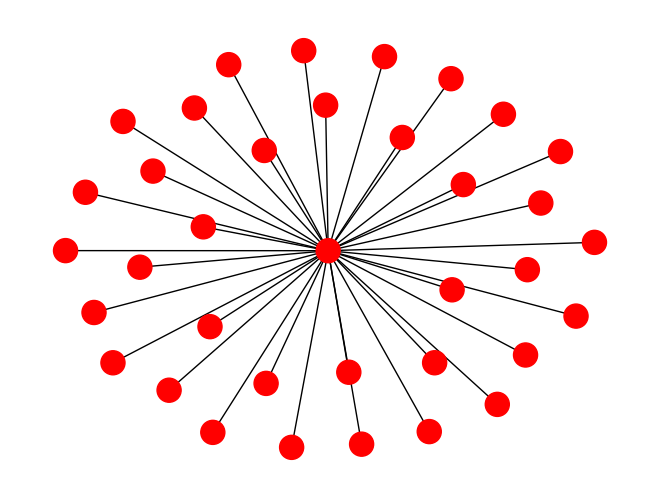

In [134]:
selected_node = df_ratio_sorted.index[0]
one_hop_edge = selected_edges[(selected_edges.ID1 == selected_node)|(selected_edges.ID2 == selected_node)]
visualize_anomaly_graph(one_hop_edge)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(selected_nodes)
selected_nodes_scaled = pd.DataFrame(features_scaled, index=selected_nodes.index, columns=selected_nodes.columns)
selected_nodes_scaled